# Pedicting water levels in aquafier Auser

Knowledge of water levels in major water supply sources is a key to organising access to water for citizens. In this notebook I will try to find a way to predict futre water avaliability based on climate data from nearby location and waterbody parameters

The waterbody analysed in this notebook is located near Lucca, Tuscany, Italy. It takes most of it's water from nearby Valley Garfagnana, one of the most humid areas in Italy. 

First, I will analyse climate conditions in this part of Italy to see how climate change affects the region.

Later I'll try to make a forecasting model based on LSTM

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 5.5MB/s 
     |████████████████████████████████| 14.8MB 259kB/s 
     |████████████████████████████████| 6.5MB 42.3MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *
from statsmodels.tsa.seasonal import seasonal_decompose


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
pd.read_csv("/content/drive/MyDrive/data_science/waters/Aquifer_Auser.csv").columns

Index(['Date', 'Rainfall_Gallicano', 'Rainfall_Pontetetto',
       'Rainfall_Monte_Serra', 'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano',
       'Rainfall_Piaggione', 'Rainfall_Calavorno', 'Rainfall_Croce_Arcana',
       'Rainfall_Tereglio_Coreglia_Antelminelli',
       'Rainfall_Fabbriche_di_Vallico', 'Depth_to_Groundwater_LT2',
       'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG',
       'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC',
       'Temperature_Orentano', 'Temperature_Monte_Serra',
       'Temperature_Ponte_a_Moriano', 'Temperature_Lucca_Orto_Botanico',
       'Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL',
       'Hydrometry_Monte_S_Quirico', 'Hydrometry_Piaggione'],
      dtype='object')

In [5]:
# reading data
data = pd.read_csv("/content/drive/MyDrive/data_science/waters/Aquifer_Auser.csv")

In [6]:
# creating datetime index for data frame
data.index = pd.to_datetime(data["Date"],format="%d/%m/%Y")

In [7]:
data

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,Depth_to_Groundwater_LT2,Depth_to_Groundwater_SAL,Depth_to_Groundwater_PAG,Depth_to_Groundwater_CoS,Depth_to_Groundwater_DIEC,Temperature_Orentano,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-03-05,05/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-06,06/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-07,07/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,9.20,0.0,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-08,08/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,11.40,0.0,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-09,09/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,11.40,0.0,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,26/06/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.36,0.00,-2.04,0.00,-3.83,23.20,20.75,0.0,23.75,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.20,-1.03
2020-06-27,27/06/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.36,-5.50,-2.10,-5.71,-3.84,23.60,21.35,0.0,24.30,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.21,-1.03
2020-06-28,28/06/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.37,-5.49,-2.14,-5.73,-3.84,24.00,21.75,0.0,24.55,-6829.936207,-7455.505,-8724.261667,-5809.63,-3000.1,0.23,-1.03


# 1. What are we talking about?

This part of the notebook contains description of the well's location and climate conditions in this part of Italy.

Where is Aquafier Auser?

In [8]:
# rainfall and temperature measurement locations
locs = data.columns[1:11]


rain_locs = {"Gallicano":(44.0619629,10.4138525),
             "Pontetetto":(43.8275956,10.4873512),
             "Monte_Serra":(43.7507554,10.5161702),
             "Orentano":(43.7772068,10.6555081),
             "Borgo_a_Mozzano":(43.980587,10.5343555),
             "Piaggione":(43.9368017,10.5019042),
             "Calavorno":(44.0201734,10.5314673),
             "Croce_Arcana":(44.1351787,10.7672312),
             "Tereglio_Coreglia_Antelminelli":(44.0642279,10.5163791),
             "Fabbrichie_di_Vallico":(44.0126462,10.3992665)}
temp_locs = {"Orentano":(43.7772068,10.6555081),
             "Monte_Serra":(43.7507554,10.5161702),
             "Ponte_a_Mariano":(43.91031,10.5199918),
             "Lucca":(43.8412616,10.5085545,17)}
rain = pd.DataFrame({"Name":list(rain_locs.keys()),"Lat":[x[1] for x in rain_locs.values()],
                     "Long":[x[0] for x in rain_locs.values()]})
temp =  pd.DataFrame({"Name":list(temp_locs.keys()),"Lat":[x[1] for x in temp_locs.values()],
                     "Long":[x[0] for x in temp_locs.values()]})

In [9]:
# reprojecting points to pseudo mercator projection
from scripts import geodf_create_transform
temp = geodf_create_transform(temp,"Lat","Long").drop("geometry",axis=1)
rain = geodf_create_transform(rain,"Lat","Long").drop("geometry",axis=1)

/content/scripts.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.x_crds[i] = list(gdf.geometry[i].coords)[0][0]
/content/scripts.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.y_crds[i] = list(gdf.geometry[i].coords)[0][1]


In [10]:
# specifying map range
from scripts import get_max_min
y_max,x_max = 44.1821938,10.9538363
y_min,x_min = 43.7441939,10.1673783
x_range,y_range = get_max_min(x_max,x_min,y_max,y_min)

In [11]:
# plotting map

# representing data in ColumnDataSource format
temp_source = ColumnDataSource(temp)
rain_source = ColumnDataSource(rain)

# specifying plot range
plot=figure(
    title="Locations of measuring stations for Aquifier Auer",
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=x_range,
    y_range=y_range,
    x_axis_type='mercator',
    y_axis_type='mercator'
    )
# specifying map provider and plotting map
tile_provider = get_provider(OSM)
map_=plot.add_tile(tile_provider)
map_.level='underlay'

# plotting markers for locations of rain and temperature measurement stations
c = plot.circle("x_crds", "y_crds",source=temp_source, size=10, color="red",alpha=0.5,legend_label="Temperature")
c1 = plot.circle("x_crds", "y_crds",source=rain_source, size=10, color="blue",alpha=0.5,legend_label="Rain")

# creating hoover tools
hover_c = HoverTool(tooltips=[("Name","@Name")],mode='mouse',point_policy='follow_mouse',renderers=[c])
hover_c1 = HoverTool(tooltips=[("Name","@Name")],mode='mouse',point_policy='follow_mouse',renderers=[c1])
plot.tools.append(hover_c)
plot.tools.append(hover_c1)


# showing plot
show(plot)
output_notebook()

As we can see on the map, rainfall is measured in couple locations near Lucca and Pisa and in several points in the Garfagnana Valley in Apuan Alps above Lucca. Temperature is measured in Lucca and in two locations outside of the Valley. The waterbody is probably located in the Lucca area

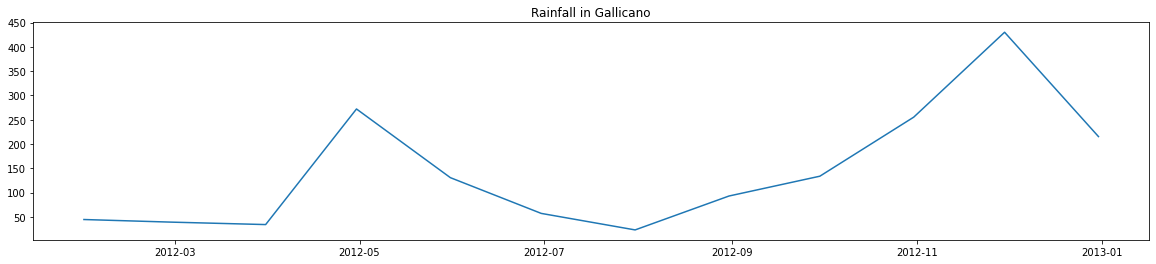

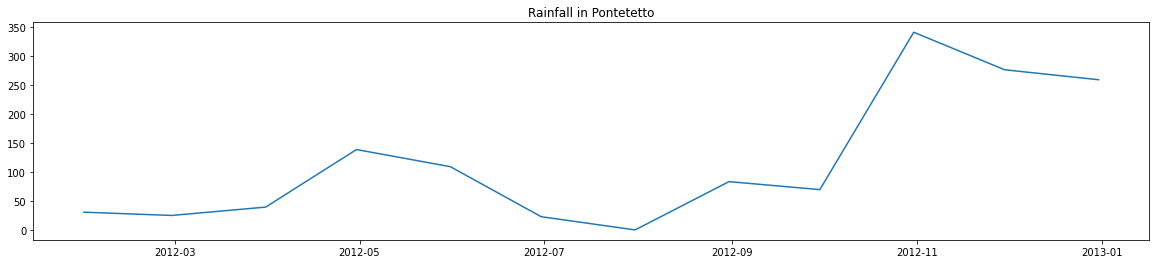

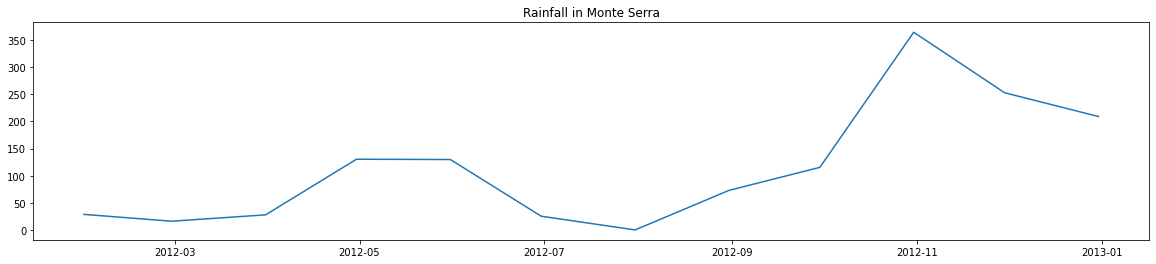

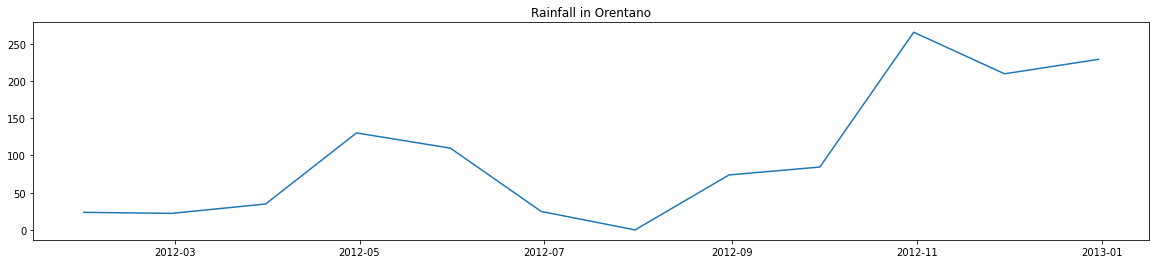

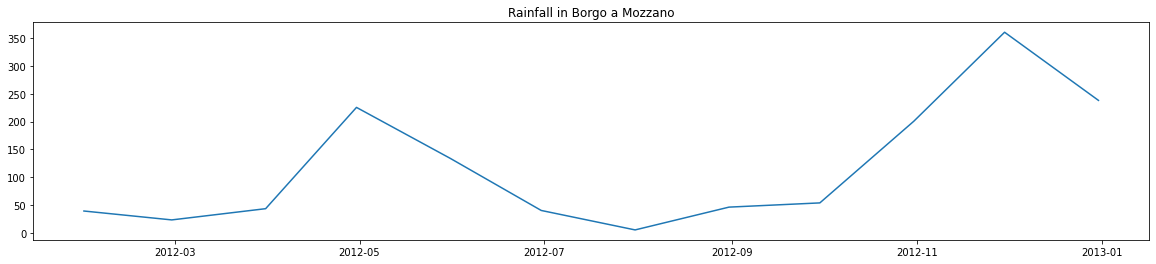

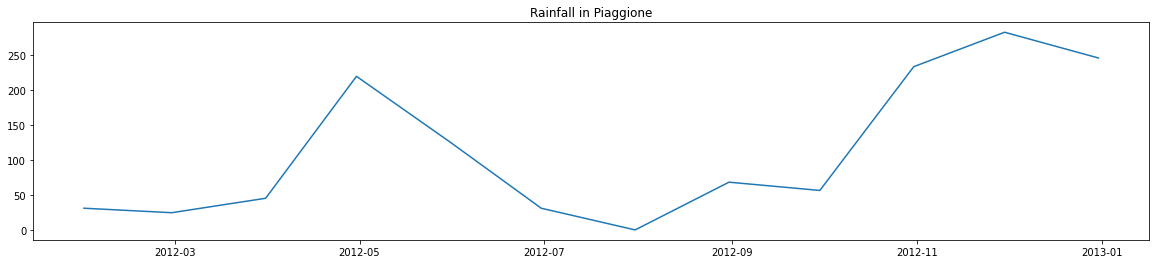

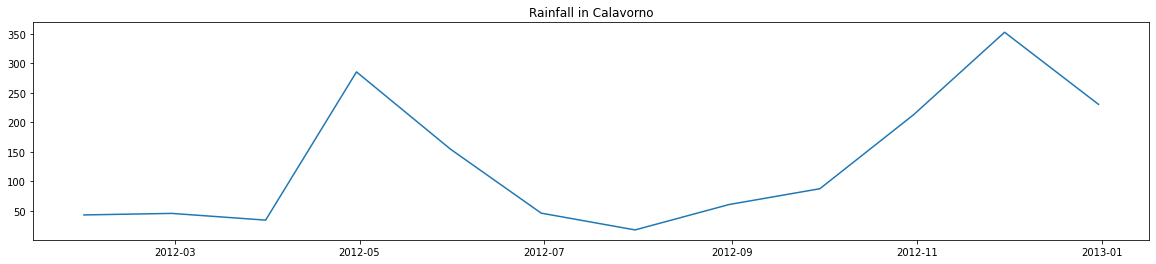

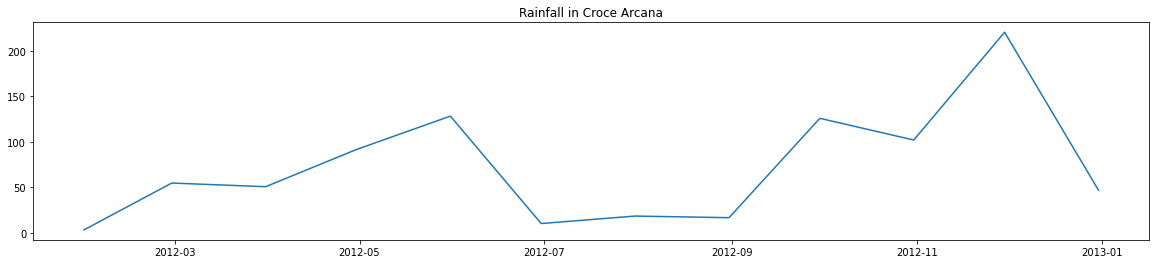

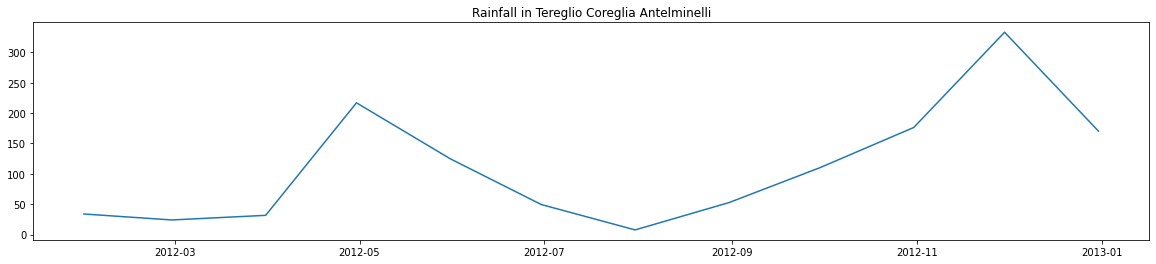

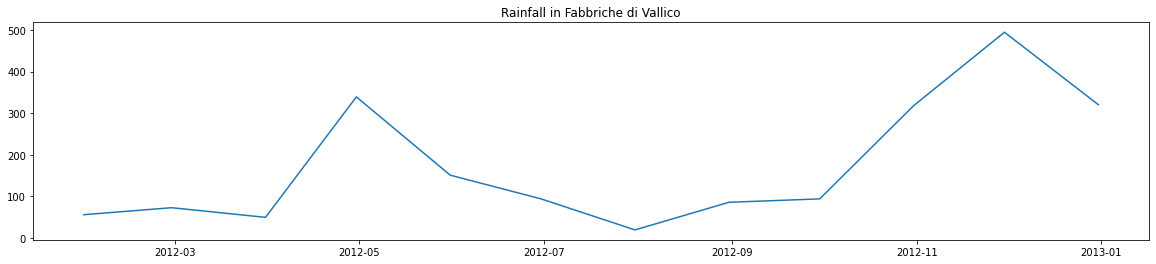

In [12]:
# grouping data by month and by year
monthly = data.groupby(pd.Grouper(freq='M')).sum()
yearly = data.groupby(pd.Grouper(freq="Y")).sum()

# columns with rainfall measurements
rainfall_cols = data.columns[1:11]

# plotting monthly rain levels for one year
for col in rainfall_cols:
    plt.figure(figsize=(20,4))
    plt.plot(monthly[pd.to_datetime("2012-01-01"):pd.to_datetime("2013-01-01")][col])
    plt.title(f"Rainfall in {' '.join(col.split('_')[1:])}")
    plt.show()

Wet seasons in the area generally are spring and autumn, with pretty dry winters and summers

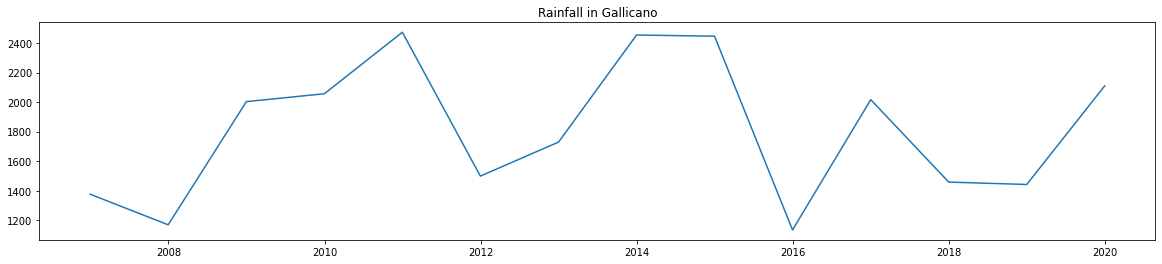

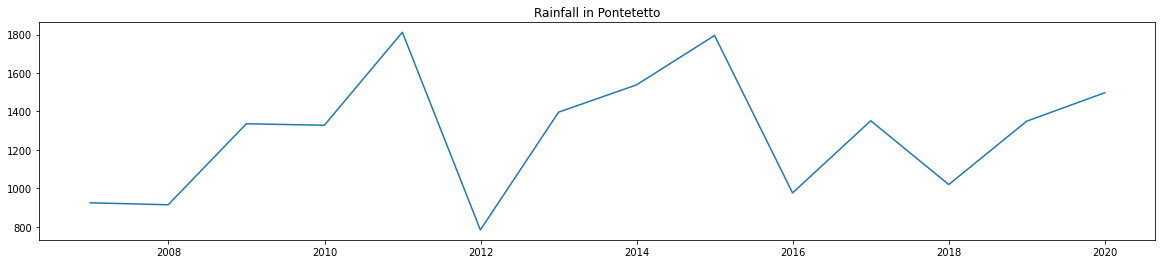

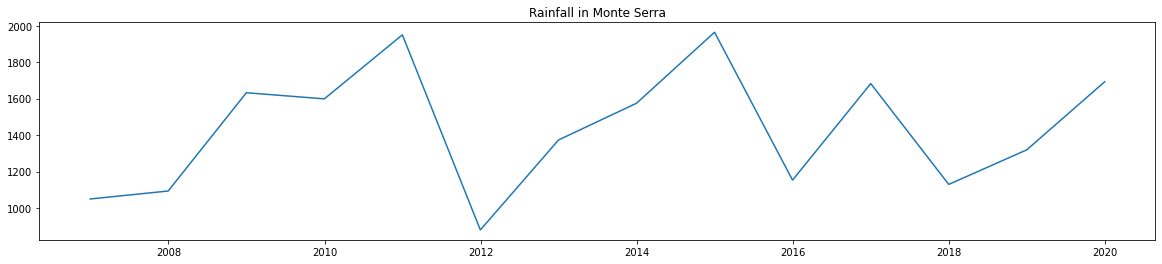

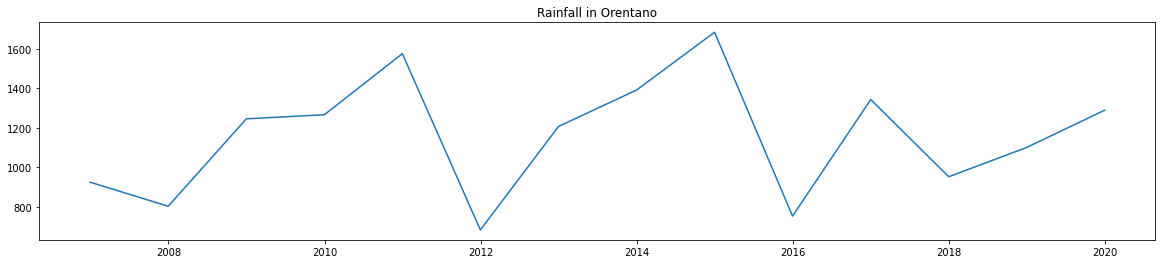

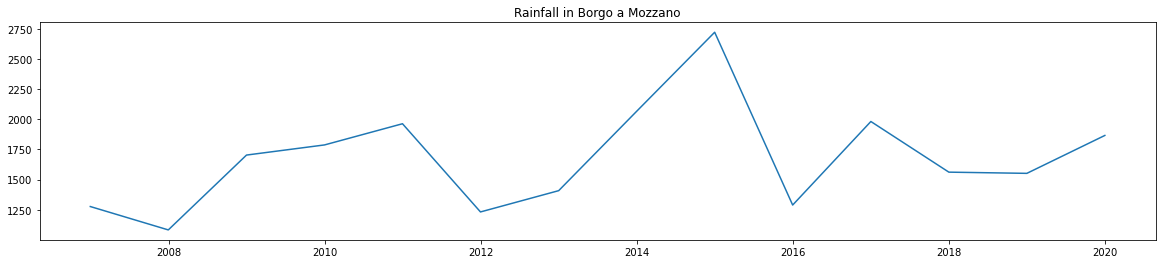

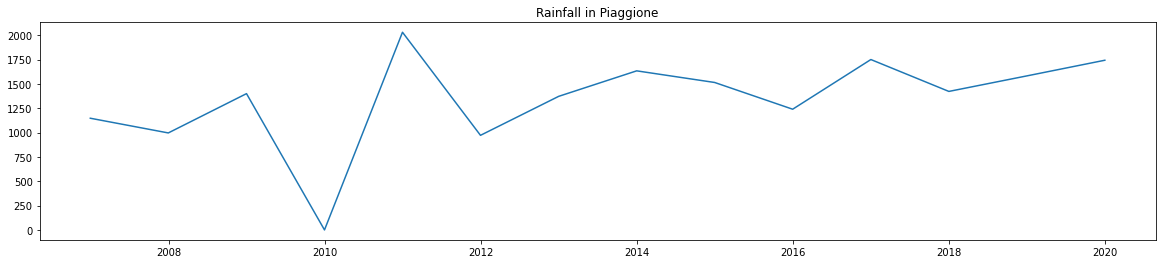

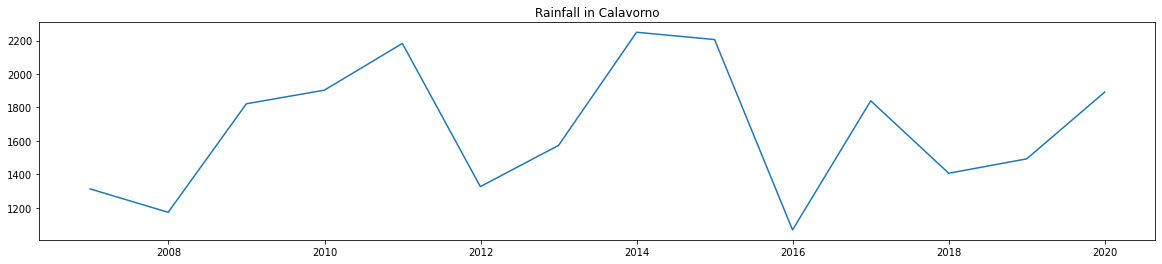

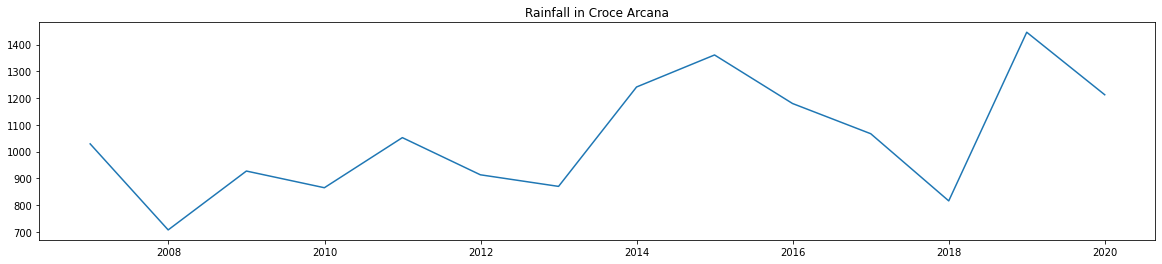

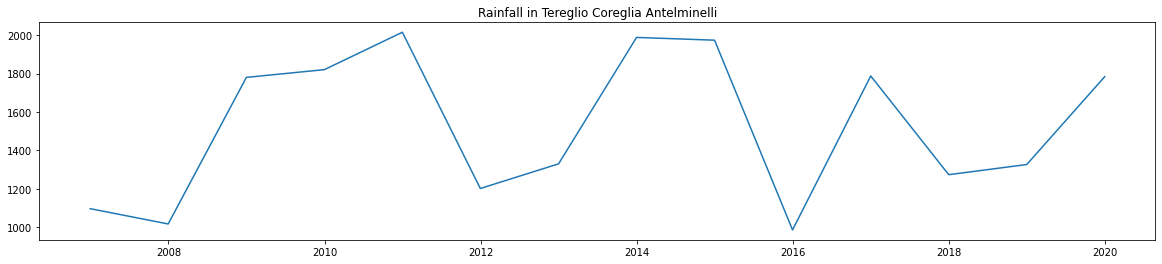

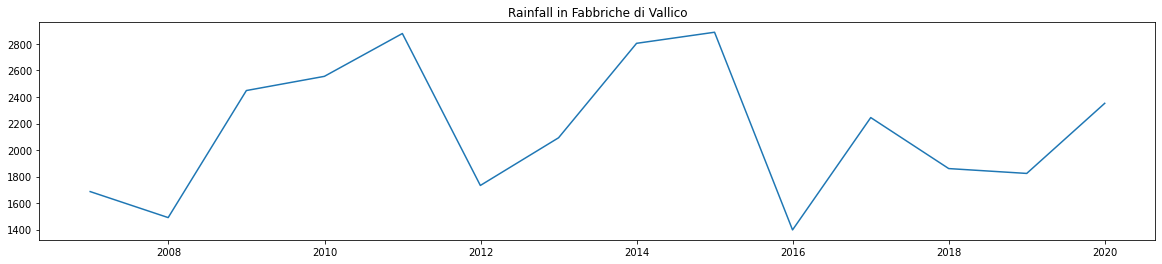

In [13]:
#plotting yearly total rainfall in the area
for col in rainfall_cols:
    plt.figure(figsize=(20,4))
    plt.plot(yearly[pd.to_datetime("2006-01-01"):pd.to_datetime("2020-01-01")][col])
    plt.title(f"Rainfall in {' '.join(col.split('_')[1:])}")
    plt.show()

There seem to be no major trend in yearly rainfall in this part of Italy. Generally dataset spans over to small period to observe clear climate trends. We will see this next with temperature

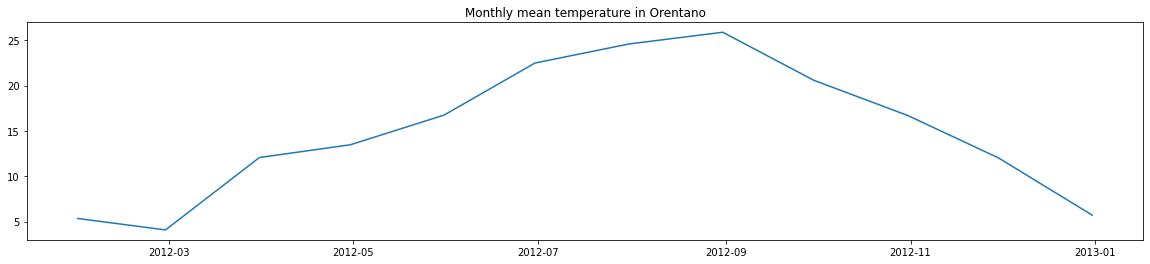

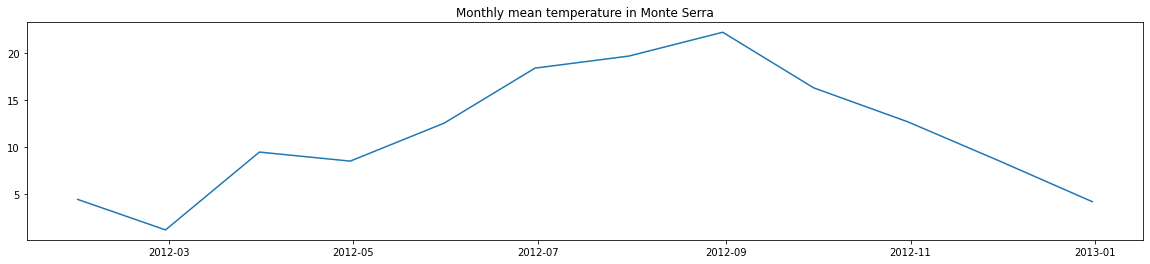

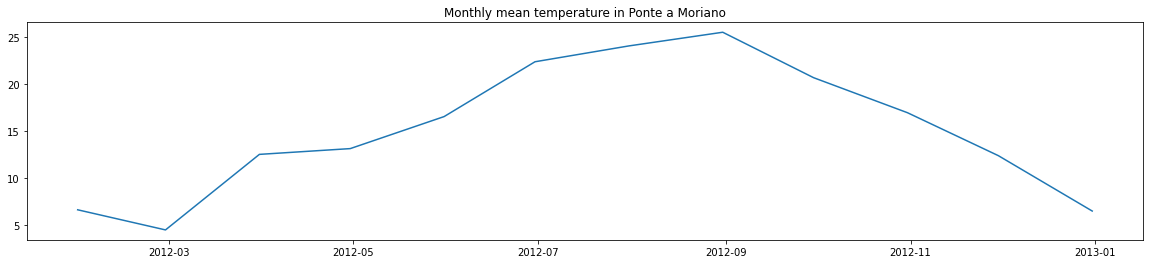

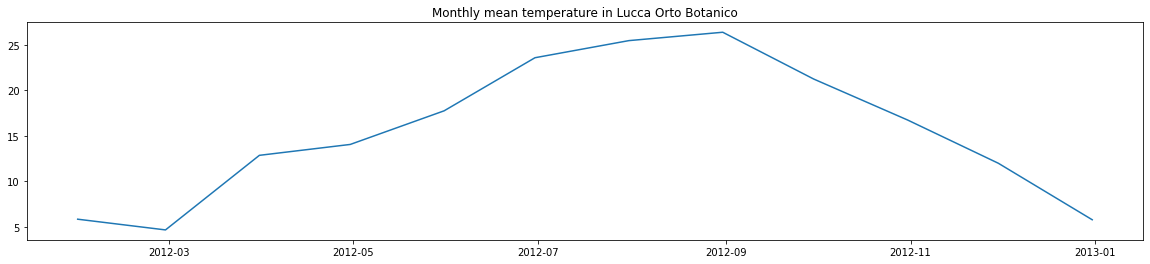

In [14]:

monthly = data.groupby(pd.Grouper(freq='M')).mean()
yearly = data.groupby(pd.Grouper(freq="Y")).mean()


temp_cols = data.columns[16:20]

for col in temp_cols:
    plt.figure(figsize=(20,4))
    plt.plot(monthly[pd.to_datetime("2012-01-01"):pd.to_datetime("2013-01-01")][col])
    plt.title(f"Monthly mean temperature in {' '.join(col.split('_')[1:])}")
    plt.show()

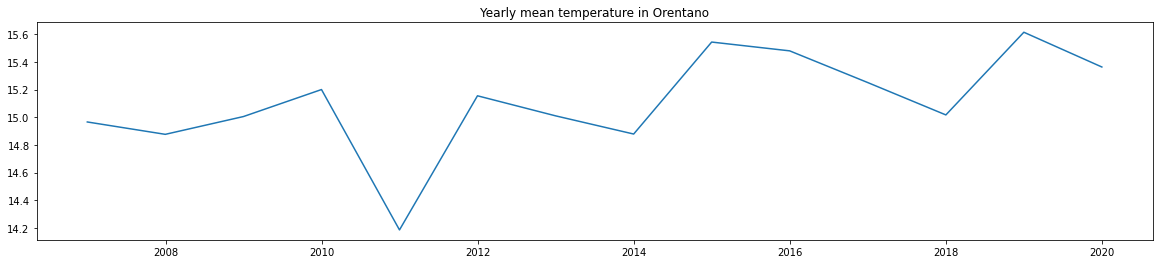

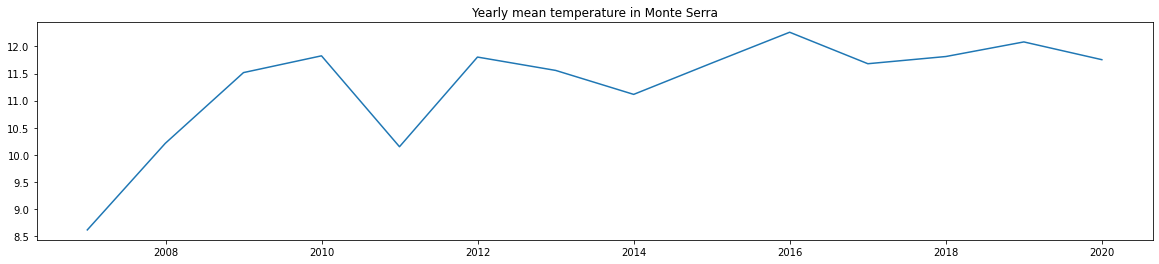

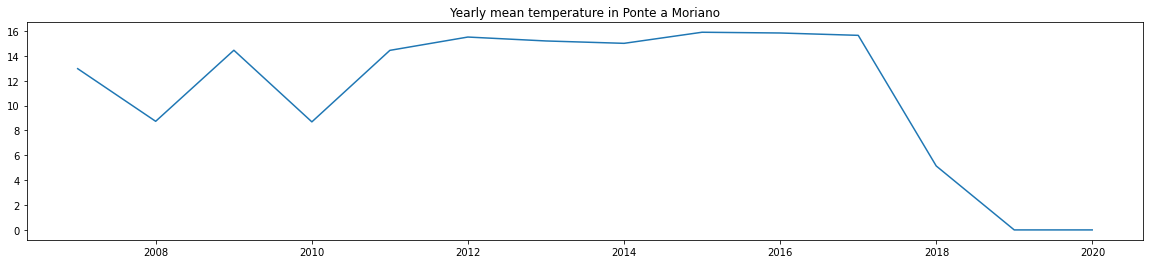

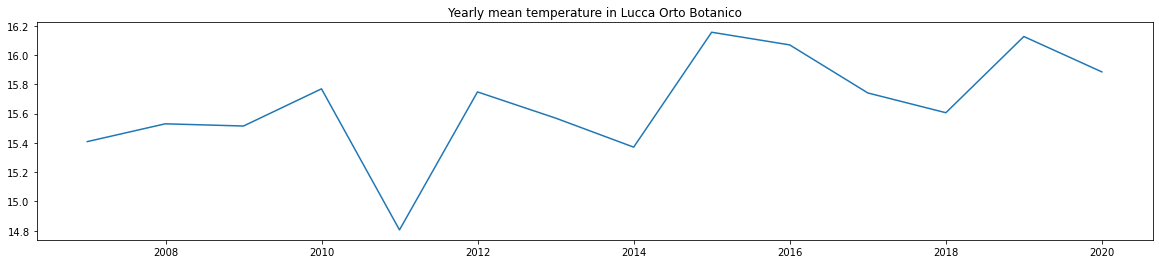

In [15]:
for col in temp_cols:
    plt.figure(figsize=(20,4))
    plt.plot(yearly[pd.to_datetime("2006-01-01"):pd.to_datetime("2020-01-01")][col])
    plt.title(f"Yearly mean temperature in {' '.join(col.split('_')[1:])}")
    plt.show()

There does not seem to be a trend in mean yearly temperatures for four sites in the dataset. In Lucca, Monte Serra and Orentano we can maybe see a faint growing trend. However, this dataset only spans 14 years of measurements. In the next part we will see historical data concerning mean yearly temperatures from Florence, capital of the region, located about 80 kilometers east from Lucca.

In [16]:
florence_climate = pd.read_csv("florence.csv")

In [17]:
florence_climate

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,2342386,1743-11-01,8.285,1.843,Florence,Italy,44.20N,11.18E
1,2342387,1743-12-01,NaN,NaN,Florence,Italy,44.20N,11.18E
2,2342388,1744-01-01,NaN,NaN,Florence,Italy,44.20N,11.18E
3,2342389,1744-02-01,NaN,NaN,Florence,Italy,44.20N,11.18E
4,2342390,1744-03-01,NaN,NaN,Florence,Italy,44.20N,11.18E
...,...,...,...,...,...,...,...,...
3234,2345620,2013-05-01,14.957,0.447,Florence,Italy,44.20N,11.18E
3235,2345621,2013-06-01,19.861,0.903,Florence,Italy,44.20N,11.18E
3236,2345622,2013-07-01,23.899,0.620,Florence,Italy,44.20N,11.18E
3237,2345623,2013-08-01,23.133,1.096,Florence,Italy,44.20N,11.18E


In [18]:
florence_climate["year"] = [int(x[0:4]) for x in florence_climate.dt]
florence_climate = florence_climate[florence_climate.year > 1800]

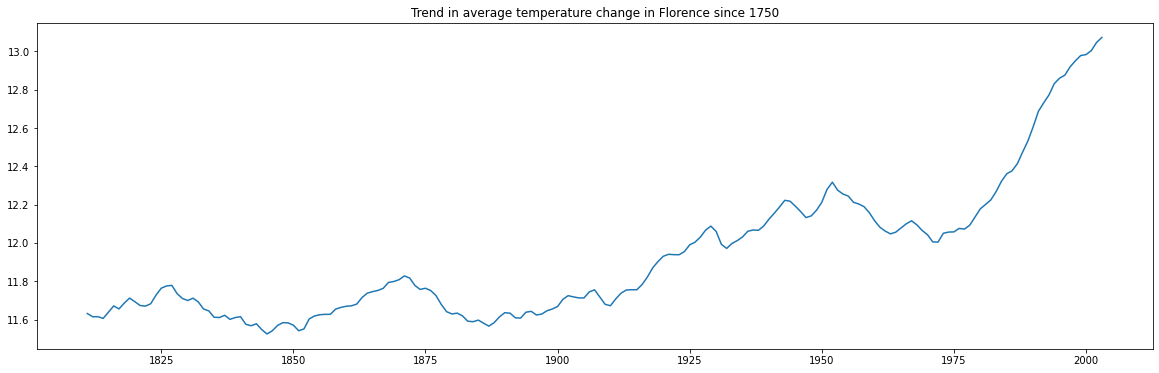

In [19]:
plt.figure(figsize=(20,6))
trend = seasonal_decompose(florence_climate.groupby("year").mean()["AverageTemperature"],freq=20).trend
plt.plot(trend)
plt.title("Trend in average temperature change in Florence since 1750")
plt.show()

## Summary
Although it the climate change isnt clearly visible in our dataset, here we can clearly see how it affects Tuscany. Mean yearly temperatures in Florence were around 11.7 celcius throughout whole XIX century and at the beggining of XX century. After 1920 we can see growth of the mean yearly temperatures, rapidly accelerating in 1980s. Right now yearly mean hits 13 celcius, with no signs of stopping. 

Higher temperatures mean higher vaporization and in succession less water. The also mean that agriculture is going to need more water. That's why it is important to keep control of the water sources and their avaliability to supply our needs. In the century of Climate Crisis we need to know how much water we have and also how much of it we will have in a week, month, etc.

# 2. Exploratory analysis

Checking if data is a timeseries, looking for correlations, viewing data

In [20]:
# dropping columns concerning other waterbodies than target

sal = data.drop(["Depth_to_Groundwater_CoS","Depth_to_Groundwater_LT2","Depth_to_Groundwater_PAG","Depth_to_Groundwater_DIEC"],axis=1)


In [21]:
data[["Depth_to_Groundwater_SAL"]].describe()

,Depth_to_Groundwater_SAL
count,4545.000000
mean,-5.651274
std,0.642939
min,-7.000000
25%,-6.040000
50%,-5.680000
75%,-5.300000
max,0.000000


Checking if data is a timeseries

In [22]:
# does index have fixed frequency?
print(pd.infer_freq(data.index))

D


In [23]:
# is index the same as sorted index
np.unique((data.index == data.index.sort_values()),return_counts=True)

(array([ True]), array([8154]))

Data is in timeseries format - stable frequency (daily), right order

We need to identify whether there are gaps in the data or our targets only start later in data

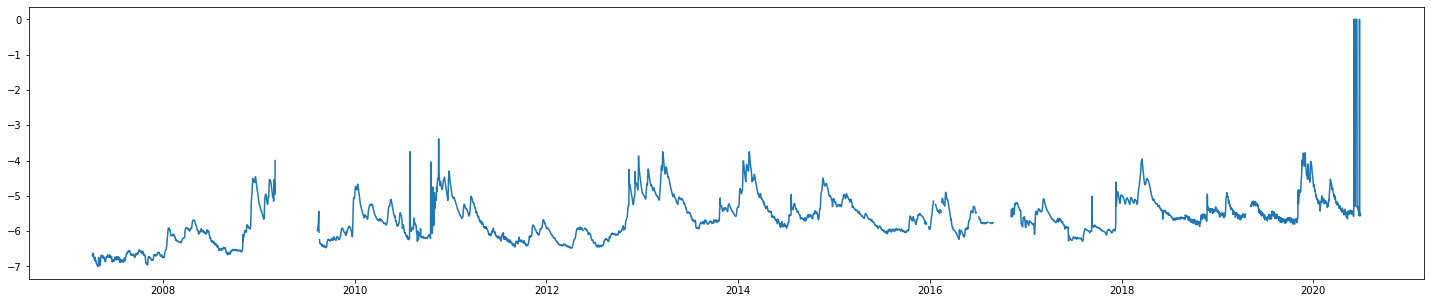

In [24]:
plt.figure(figsize=(25,5))
plt.plot(sal.Depth_to_Groundwater_SAL)

In [25]:
sal = sal[pd.to_datetime("2010-01-01"):]

In [26]:
sal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2010-01-01 to 2020-06-30
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     3834 non-null   object 
 1   Rainfall_Gallicano                       3834 non-null   float64
 2   Rainfall_Pontetetto                      3834 non-null   float64
 3   Rainfall_Monte_Serra                     3828 non-null   float64
 4   Rainfall_Orentano                        3834 non-null   float64
 5   Rainfall_Borgo_a_Mozzano                 3834 non-null   float64
 6   Rainfall_Piaggione                       3834 non-null   float64
 7   Rainfall_Calavorno                       3834 non-null   float64
 8   Rainfall_Croce_Arcana                    3834 non-null   float64
 9   Rainfall_Tereglio_Coreglia_Antelminelli  3834 non-null   float64
 10  Rainfall_Fabbriche_di_Vallico 

Data start only after 2006 or 2007, we can drop historical data with no informations about the groundwater depth. There is a problem with constant frequency of the target. Most features have consistent, daily information as to what their level is. Where there are gaps, simple interpolation should be enough. Targets however contain pretty big gaps. 

The plan is to start with early fragments of uninterrupted data (for ex. from 2010 to 2016 for SAL aquifier, one we're modelling), model these parts, and depending on data structure use these parts as training set or fill in missing values and then split data and model full TS use this model to imput missing values.

But before that, let's see how features interact with each other



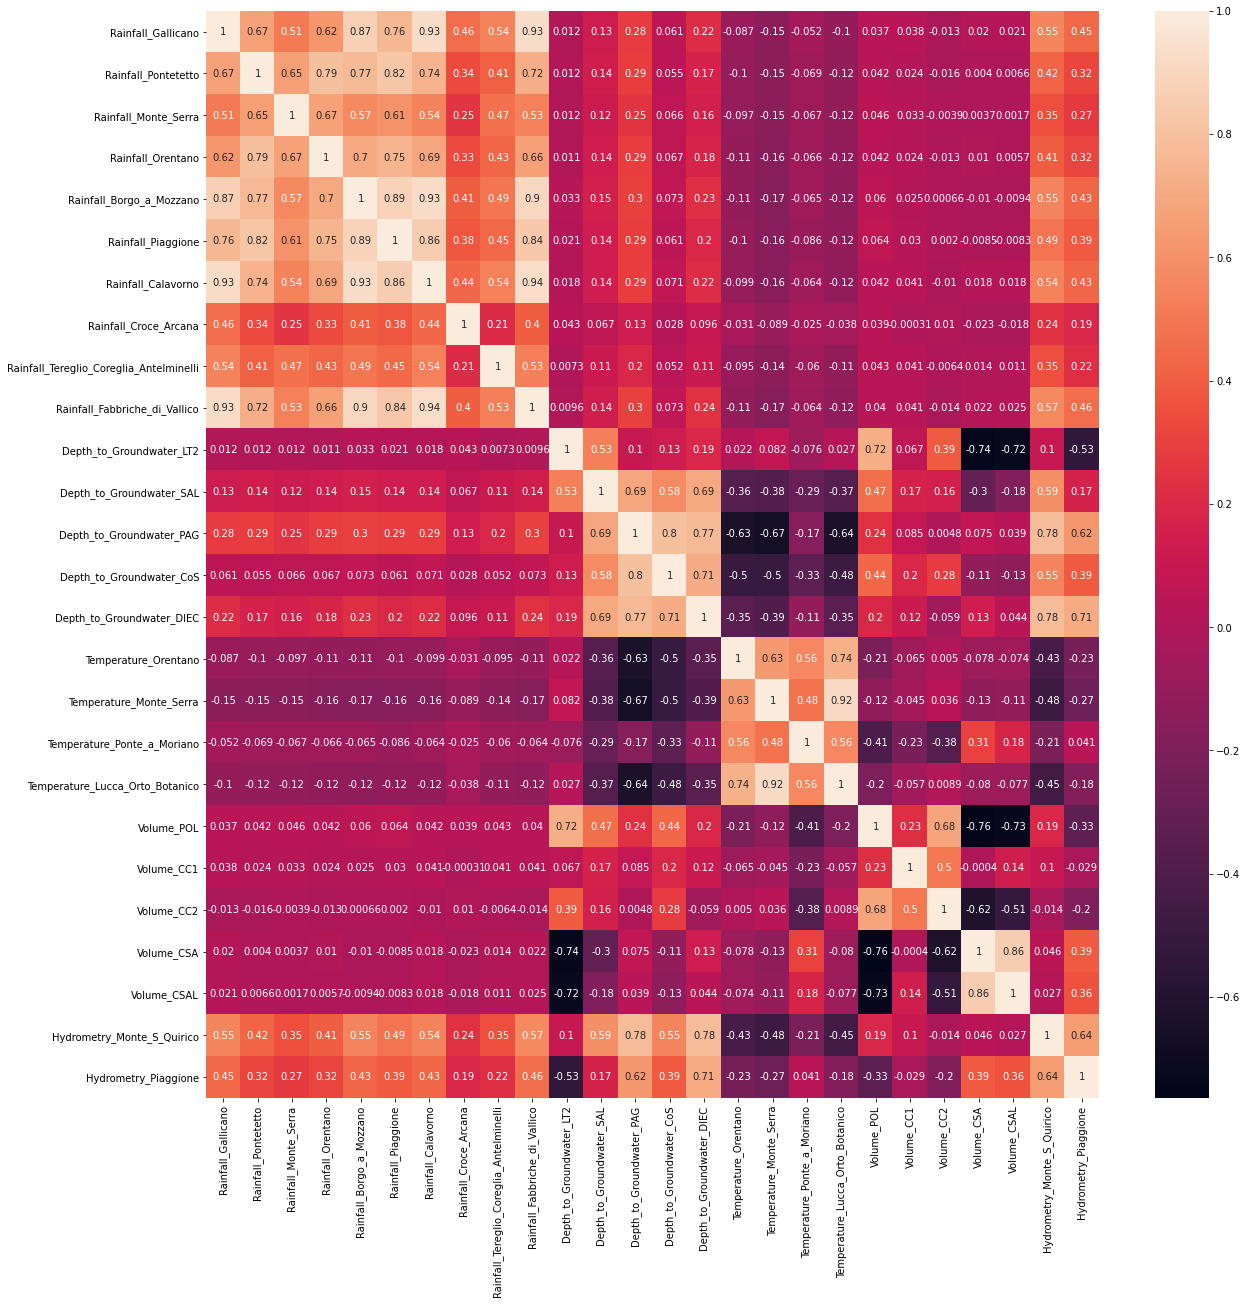

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=True)

Generally speaking, rain is (weakly) positively correlated whereas temperature is correlated negatively. Volumes and hydrometries do not follow clear patterns and affect levels differently.

# 3.Building models

For now, we will only model the SAL well.

We will start by separating long period of uninterrupted data on target variable and building a model predicting water levels for the next day based on it.

In [28]:
# importing libraries useful when working with timeseries data and data preparations
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [29]:
# choosing data from 2010 to 2016, interpolating missing values
sal_fill_missing = sal[pd.to_datetime("2010-01-01"):pd.to_datetime("2016-01-01")].interpolate("linear").drop(["Date","Hydrometry_Piaggione"],axis=1)

In [30]:
def prepare_seq(X,y,flen,tlen):
        """
        Function prepares data for timeseries modelling with LSTMs. Data should be split into sequences of features
        spanning the chosen feature period and sequences of targets spanning chosen target period

        X - features
        y - target
        flen - length of feature period for the timeseries prediction
        tlen - length of target period
        """
        x = list()
        tar = list()
        for i in range(len(X)):
            end_idx = i+flen+tlen
            if end_idx > len(X):
                break
            seq_feat = X[i:(i+flen)]
            seq_tar = y[(i+flen):end_idx]
            x.append(seq_feat)
            tar.append(seq_tar)
        return np.array(x),np.array(tar)

In [31]:
# defining features and target
X= sal_fill_missing
y = sal_fill_missing["Depth_to_Groundwater_SAL"]

In [32]:
# scaling data with two separate scalers, allowing inverse scaling on target later when needed


scl_features = MinMaxScaler()
X = scl_features.fit_transform(X)
scl_target = MinMaxScaler()
y = scl_target.fit_transform(y.to_numpy().reshape(-1,1))

In [33]:
# preparing sequences 
X,y = prepare_seq(X,y,730,1)

In [34]:
# splitting into training and validation sets

X_train, X_valid = X[:-200],X[-200:]
y_train, y_valid = y[:-200],y[-200:]

In [35]:
# making sure that training set does not contain NaNs
np.isnan(X).sum()

0

In [36]:
X[0], y[0]

(array([[0.15997491, 0.34789916, 0.25820896, ..., 1.        , 1.        ,
         0.67816092],
        [0.05332497, 0.05378151, 0.        , ..., 1.        , 1.        ,
         0.54597701],
        [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
         0.43678161],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
         0.15517241],
        [0.00125471, 0.00168067, 0.        , ..., 1.        , 1.        ,
         0.14942529],
        [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
         0.12643678]]), array([[0.17741935]]))

In [37]:
# importing Deep Learning libraries
from tensorflow.keras import regularizers, optimizers

from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import History,EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError as rmse

# Model choice

I chose LSTM as my model of choice for this task to use it's powers of sequence predictions and it's ability to learn long term relationships

In [38]:
# Defining model - two stacked LSTM's, one hidden Dense layer and output layer

model = Sequential()

model.add(LSTM(128,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
model.add(Activation("relu"))

model.add(LSTM(128))
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Activation("relu"))


model.add(Dense(y.shape[1],activation="linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 730, 128)          76800     
_________________________________________________________________
activation (Activation)      (None, 730, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [39]:
# defining callbacks, optimizer and compiling model

history = History()
Adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
save = ModelCheckpoint("auser_1.h5",save_best_only=True)
model.compile(loss="mse",optimizer=Adam,metrics=[rmse()])

In [40]:
# fitting model on prepred data
model.fit(X_train,y_train, validation_data=(X_valid,y_valid),epochs=4,batch_size=32,callbacks=[history,save])

Epoch 1/4
40/40 [==============================] - 68s 2s/step - loss: 0.0343 - root_mean_squared_error: 0.1762 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 2/4
40/40 [==============================] - 63s 2s/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 3/4
40/40 [==============================] - 62s 2s/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 4/4
40/40 [==============================] - 62s 2s/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581


In [41]:
# preparing predictions and true values for further evaluation - inverse scaling
preds = scl_target.inverse_transform(model.predict(X))
y = scl_target.inverse_transform(y.reshape(y.shape[0],y.shape[1]))

In [42]:
# importing metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [43]:
print(f"mse: {mean_squared_error(y,preds)}, r2_scr: {r2_score(y,preds)}, mae: {mean_absolute_error(y,preds)} ")

mse: 0.010219451217716174, r2_scr: 0.9674362938324981, mae: 0.07110340196293777 


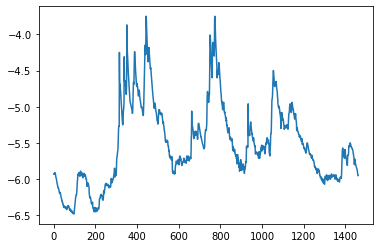

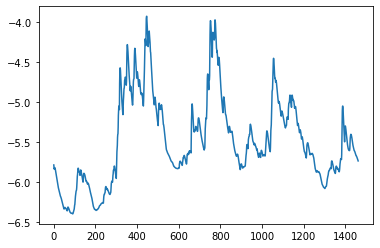

In [44]:
# plotting true values and predictions
plt.plot(y)
plt.show()
plt.plot(preds)
plt.show()

In [45]:
# updating data with data already used in training with imputed missing values
sal[pd.to_datetime("2010-01-01"):pd.to_datetime("2016-01-01")] = sal_fill_missing

In [46]:
sal.drop("Date",axis=1,inplace=True)

In [47]:
# looking for indices where target data is missing
idxs = sal[sal["Depth_to_Groundwater_SAL"].isna() == True].index
  

In [48]:
# predicting missing values using trained model
import warnings
warnings.filterwarnings("ignore")

for idx in idxs:
  features = sal.loc[pd.to_datetime(idx)-pd.Timedelta(730,"D"):pd.to_datetime(idx)-pd.Timedelta(1,"D")].drop("Hydrometry_Piaggione",axis=1)
  features = scl_features.fit_transform(features).reshape(1,features.shape[0],features.shape[1])

  sal["Depth_to_Groundwater_SAL"].loc[idx] = scl_target.inverse_transform(model.predict(features))

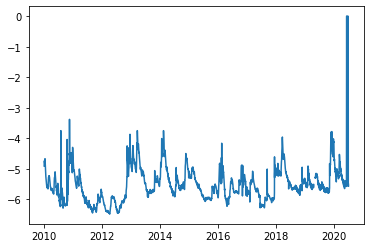

In [49]:
plt.plot(sal["Depth_to_Groundwater_SAL"])

In [50]:
sal = sal.interpolate("linear")
sal = sal[:pd.to_datetime("2020-01-01")].drop("Hydrometry_Piaggione",axis=1)

In [51]:
sal.isna().sum()

Rainfall_Gallicano                         0
Rainfall_Pontetetto                        0
Rainfall_Monte_Serra                       0
Rainfall_Orentano                          0
Rainfall_Borgo_a_Mozzano                   0
Rainfall_Piaggione                         0
Rainfall_Calavorno                         0
Rainfall_Croce_Arcana                      0
Rainfall_Tereglio_Coreglia_Antelminelli    0
Rainfall_Fabbriche_di_Vallico              0
Depth_to_Groundwater_SAL                   0
Temperature_Orentano                       0
Temperature_Monte_Serra                    0
Temperature_Ponte_a_Moriano                0
Temperature_Lucca_Orto_Botanico            0
Volume_POL                                 0
Volume_CC1                                 0
Volume_CC2                                 0
Volume_CSA                                 0
Volume_CSAL                                0
Hydrometry_Monte_S_Quirico                 0
dtype: int64

# Final model

Model takes data on previous 3 years of measurements and predicts next days water level

In [64]:
# defining feature and targets
X= sal
y = sal["Depth_to_Groundwater_SAL"]

In [65]:
# scaling data

scl_features = MinMaxScaler()
X = scl_features.fit_transform(X)
scl_target = MinMaxScaler()
y = scl_target.fit_transform(y.to_numpy().reshape(-1,1))

In [66]:
# preparing sequences
X,y = prepare_seq(X,y,1095,1)

In [67]:
X.shape

(2558, 1095, 21)

In [68]:
# train test split
X_train, X_valid = X[:-200],X[-200:]
y_train, y_valid = y[:-200],y[-200:]

In [69]:
# same architecture as above, output is a vector with predictions for 7 days
model = Sequential()

model.add(LSTM(128,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
model.add(Activation("relu"))

model.add(LSTM(128))
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Activation("relu"))


model.add(Dense(y.shape[1],activation="linear"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1095, 128)         76800     
_________________________________________________________________
activation_6 (Activation)    (None, 1095, 128)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_8 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [73]:
# defining callbacks, optimizer and compiling model
history = History()
Adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
save = ModelCheckpoint("auser_1.h5",save_best_only=True)
model.compile(loss="mse",optimizer=Adam,metrics=[rmse()])

In [74]:
model.fit(X_train,y_train, validation_data=(X_valid,y_valid),epochs=3,batch_size=32,callbacks=[history,save])

Epoch 1/3
74/74 [==============================] - 174s 2s/step - loss: 0.0053 - root_mean_squared_error: 0.0703 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 2/3
74/74 [==============================] - 170s 2s/step - loss: 0.0012 - root_mean_squared_error: 0.0337 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 3/3
74/74 [==============================] - 166s 2s/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325


In [60]:
# checking predictions, inversing scaling
pred = scl_target.inverse_transform(model.predict(X[-1].reshape(1,1095,21)))


Last model - can we predict aquifier's water level using only weather data? 
This model will probably be less accurate, but could supply predictions based on weather forecasts

In [81]:
# defining feature and targets
x_cols = list(sal.columns[0:10])+ list(sal.columns[11:15])
X= sal[x_cols]
y = sal["Depth_to_Groundwater_SAL"]

In [82]:
x_cols

['Rainfall_Gallicano',
 'Rainfall_Pontetetto',
 'Rainfall_Monte_Serra',
 'Rainfall_Orentano',
 'Rainfall_Borgo_a_Mozzano',
 'Rainfall_Piaggione',
 'Rainfall_Calavorno',
 'Rainfall_Croce_Arcana',
 'Rainfall_Tereglio_Coreglia_Antelminelli',
 'Rainfall_Fabbriche_di_Vallico',
 'Temperature_Orentano',
 'Temperature_Monte_Serra',
 'Temperature_Ponte_a_Moriano',
 'Temperature_Lucca_Orto_Botanico']

In [83]:
# scaling data

scl_features = MinMaxScaler()
X = scl_features.fit_transform(X)
scl_target = MinMaxScaler()
y = scl_target.fit_transform(y.to_numpy().reshape(-1,1))

X,y = prepare_seq(X,y,1095,1)

X_train, X_valid = X[:-200],X[-200:]
y_train, y_valid = y[:-200],y[-200:]

In [84]:
model = Sequential()

model.add(LSTM(128,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
model.add(Activation("relu"))

model.add(LSTM(128))
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Activation("relu"))


model.add(Dense(y.shape[1],activation="linear"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1095, 128)         73216     
_________________________________________________________________
activation_9 (Activation)    (None, 1095, 128)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_11 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [87]:
# defining callbacks, optimizer and compiling model
history = History()
Adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
save = ModelCheckpoint("auser_meteorology.h5",save_best_only=True)
model.compile(loss="mse",optimizer=Adam,metrics=[rmse()])

In [88]:
model.fit(X_train,y_train, validation_data=(X_valid,y_valid),epochs=5,batch_size=32,callbacks=[history,save])

Epoch 1/5
74/74 [==============================] - 172s 2s/step - loss: 0.0206 - root_mean_squared_error: 0.1401 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 2/5
74/74 [==============================] - 167s 2s/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 3/5
74/74 [==============================] - 167s 2s/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 4/5
74/74 [==============================] - 166s 2s/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 5/5
74/74 [==============================] - 168s 2s/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521


In [89]:
preds = scl_target.inverse_transform(model.predict(X))
y = scl_target.inverse_transform(y.reshape(y.shape[0],y.shape[1]))

In [90]:
print(f"mse: {mean_squared_error(y,preds)}, r2_scr: {r2_score(y,preds)}, mae: {mean_absolute_error(y,preds)} ")

mse: 0.03327191584657996, r2_scr: 0.8423132523960767, mae: 0.12405886496110667 


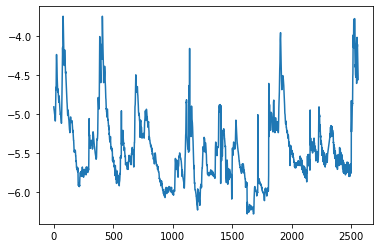

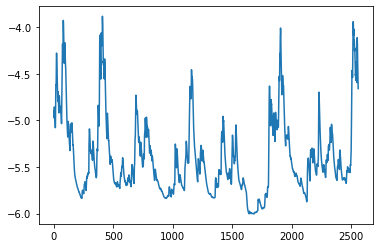

In [91]:
plt.plot(y)
plt.show()
plt.plot(preds)
plt.show()

As predicted, this model has less predictiong power, but still fits the data well enough to provide approximations based only on weather forecasts